1) Setup — install + imports

In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV
!pip install catboost
from catboost import CatBoostClassifier
import joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


2) Load data & quick EDA

In [ ]:
# Change path if needed
DATA_PATH = "/content/application_train.csv"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("TARGET distribution:\n", df['TARGET'].value_counts(normalize=True))
df.head()


Shape: (307511, 122)
TARGET distribution:
 TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = pd.read_csv("/content/application_train.csv")  # change path if needed
print("Rows,Cols:", df.shape)
print("Target distribution:\n", df['TARGET'].value_counts(dropna=False))
print("\nSome important columns if present:", [c for c in ['SK_ID_CURR','AMT_CREDIT','AMT_INCOME_TOTAL'] if c in df.columns])
# missing summary
missing = df.isnull().mean().sort_values(ascending=False).head(30)
print("\nTop missing cols:\n", missing)


Rows,Cols: (307511, 122)
Target distribution:
 TARGET
0    282686
1     24825
Name: count, dtype: int64

Some important columns if present: ['SK_ID_CURR', 'AMT_CREDIT', 'AMT_INCOME_TOTAL']

Top missing cols:
 COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
COMMONAREA_MEDI             0.698723
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_MODE       0.683550
FLOORSMIN_MODE              0.678486
FLOORSMIN_AVG               0.678486
FLOORSMIN_MEDI              0.678486
YEARS_BUILD_AVG             0.664978
YEARS_BUILD_MODE            0.664978
YEARS_BUILD_MEDI            0.664978
OWN_CAR_AGE                 0.659908
LANDAREA_MEDI               0.593767
LANDAREA_AVG                0.593767
LANDAREA_MODE               0.593767
BASEMENTAREA_MODE           0.585160
BASEMENTAREA_M

Step 2: Drop high-missing columns (optional but recommended)

In [ ]:
# Drop columns with >60% missing values
missing_ratio = df.isnull().mean()
high_missing = missing_ratio[missing_ratio > 0.60].index
df = df.drop(columns=high_missing)

print("Remaining cols:", df.shape[1])


Remaining cols: 105


3) Train/validation split

In [ ]:
TARGET = 'TARGET'
ID_COL = 'SK_ID_CURR' if 'SK_ID_CURR' in df.columns else None

y = df[TARGET]
X = df.drop(columns=[TARGET] + ([ID_COL] if ID_COL else []))

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Val shape:", X_val.shape)


Train shape: (246008, 103) Val shape: (61503, 103)


4) Preprocessing pipelines

Logistic Regression needs numeric scaled + OHE for categoricals.

CatBoost will be trained separately using raw categorical strings.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Identify columns
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


In [6]:
import pandas as pd

df = pd.read_csv('/content/application_train.csv')  # update path if needed
print(df.shape)
df.head()


(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Step 2: Basic Cleaning and Splitting

In [7]:
from sklearn.model_selection import train_test_split

# Drop ID column if present
if 'SK_ID_CURR' in df.columns:
    df = df.drop('SK_ID_CURR', axis=1)

# Target and features
y = df['TARGET']
X = df.drop('TARGET', axis=1)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Val shape:", X_val.shape)


Train shape: (246008, 120)  Val shape: (61503, 120)


Step 3: Now re-run the preprocessor cell

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


Step 4: Then finally run Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(
        max_iter=500,
        solver='lbfgs',
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])

print("Training Logistic Regression (fast mode)...")
lr_pipeline.fit(X_train, y_train)

proba_lr = lr_pipeline.predict_proba(X_val)[:,1]
auc_lr = roc_auc_score(y_val, proba_lr)
print("Logistic Regression ROC-AUC:", round(auc_lr, 4))


Training Logistic Regression (fast mode)...
Logistic Regression ROC-AUC: 0.7489


1) Install & train CatBoost

In [10]:
# run in a notebook cell (prefix with ! in Colab/Jupyter)
!pip install -q catboost


Then train:


In [11]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

# Prepare CatBoost-friendly copies
X_train_cb = X_train.copy()
X_val_cb = X_val.copy()

# Ensure categorical columns exist (recompute if needed)
cat_cols = X_train_cb.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_cb.select_dtypes(include=['int64','float64']).columns.tolist()

for c in cat_cols:
    X_train_cb[c] = X_train_cb[c].fillna('MISSING').astype(str)
    X_val_cb[c] = X_val_cb[c].fillna('MISSING').astype(str)

# fill numeric missing with median (CatBoost handles NaN but this is safe)
X_train_cb[num_cols] = X_train_cb[num_cols].fillna(X_train_cb[num_cols].median())
X_val_cb[num_cols] = X_val_cb[num_cols].fillna(X_train_cb[num_cols].median())

cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    early_stopping_rounds=30,
    verbose=100
)

print("Fitting CatBoost (prints progress)...")
cat_model.fit(X_train_cb, y_train, cat_features=cat_cols, eval_set=(X_val_cb, y_val))

proba_cb = cat_model.predict_proba(X_val_cb)[:,1]
auc_cb = roc_auc_score(y_val, proba_cb)
print("CatBoost ROC-AUC:", round(auc_cb, 4))



Fitting CatBoost (prints progress)...
0:	test: 0.6523019	best: 0.6523019 (0)	total: 1.32s	remaining: 6m 35s
100:	test: 0.7517200	best: 0.7517200 (100)	total: 1m 27s	remaining: 2m 52s
200:	test: 0.7573697	best: 0.7573697 (200)	total: 2m 56s	remaining: 1m 26s
299:	test: 0.7596591	best: 0.7596591 (299)	total: 4m 21s	remaining: 0us

bestTest = 0.7596590759
bestIteration = 299

CatBoost ROC-AUC: 0.7597


2) Business-cost threshold sweep (scalar & amount-based)

Using amount-based costs (AMT_CREDIT present).
LR best threshold: 0.655 Cost: 1533103500
CatBoost best threshold: 0.125 Cost: 1490958580


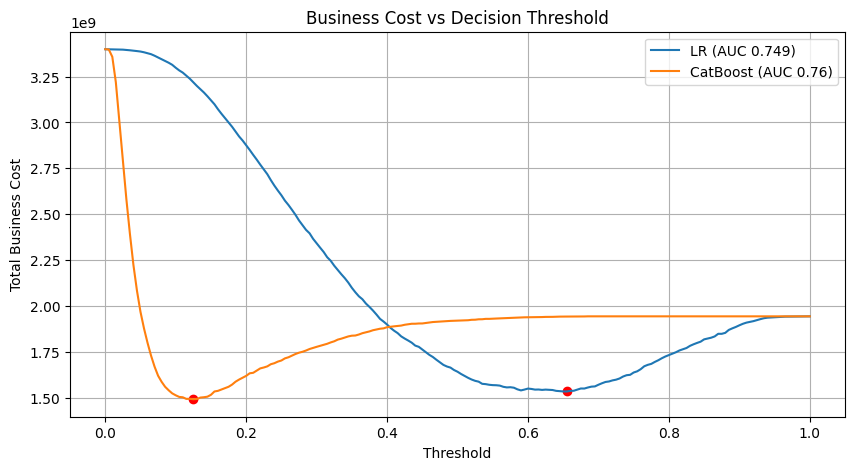

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ---------- cost setup ----------
# scalar example (adjust to your business numbers)
cost_fp = 500        # cost when you wrongly reject a good customer
cost_fn = 20000      # cost when you wrongly approve a defaulter

# amount-based (if AMT_CREDIT present)
use_amount_based = 'AMT_CREDIT' in X_val.columns
if use_amount_based:
    LGD = 0.7                 # Loss Given Default (70%)
    profit_rate = 0.10        # estimated profit per approved loan (10%)
    amt = X_val['AMT_CREDIT'].astype(float)
    cost_fp_vec = (profit_rate * amt).rename("cost_fp")
    cost_fn_vec = (LGD * amt).rename("cost_fn")
    print("Using amount-based costs (AMT_CREDIT present).")
else:
    cost_fp_vec = None
    cost_fn_vec = None
    print("AMT_CREDIT not found — using scalar costs.")

# ---------- threshold sweep function ----------
def find_optimal_threshold(y_true, proba, cost_fp, cost_fn, cost_fp_vec=None, cost_fn_vec=None, n=201):
    ths = np.linspace(0,1,n)
    records = []
    y_arr = np.array(y_true)
    for t in ths:
        y_pred = (proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_arr, y_pred, labels=[0,1]).ravel()
        if cost_fp_vec is None:
            total_cost = fp * cost_fp + fn * cost_fn
        else:
            mask_fp = (y_pred == 1) & (y_arr == 0)
            mask_fn = (y_pred == 0) & (y_arr == 1)
            total_cost = cost_fp_vec[mask_fp].sum() + cost_fn_vec[mask_fn].sum()
        records.append((t, total_cost, tn, fp, fn, tp))
    df = pd.DataFrame(records, columns=['threshold','total_cost','tn','fp','fn','tp'])
    best = df.loc[df['total_cost'].idxmin()]
    return best, df

# ---------- run for LR and CatBoost ----------
best_lr, df_lr = find_optimal_threshold(y_val.values, proba_lr, cost_fp, cost_fn, cost_fp_vec=(cost_fp_vec if use_amount_based else None), cost_fn_vec=(cost_fn_vec if use_amount_based else None))
best_cb, df_cb = find_optimal_threshold(y_val.values, proba_cb, cost_fp, cost_fn, cost_fp_vec=(cost_fp_vec if use_amount_based else None), cost_fn_vec=(cost_fn_vec if use_amount_based else None))

print("LR best threshold:", round(best_lr['threshold'],4), "Cost:", int(best_lr['total_cost']))
print("CatBoost best threshold:", round(best_cb['threshold'],4), "Cost:", int(best_cb['total_cost']))

# ---------- plot ----------
plt.figure(figsize=(10,5))
plt.plot(df_lr['threshold'], df_lr['total_cost'], label=f'LR (AUC {round(roc_auc_score(y_val, proba_lr),3)})')
plt.plot(df_cb['threshold'], df_cb['total_cost'], label=f'CatBoost (AUC {round(roc_auc_score(y_val, proba_cb),3)})')
plt.scatter([best_lr['threshold'], best_cb['threshold']], [best_lr['total_cost'], best_cb['total_cost']], color='red')
plt.xlabel('Threshold')
plt.ylabel('Total Business Cost')
plt.title('Business Cost vs Decision Threshold')
plt.legend()
plt.grid(True)
plt.show()


3) Show metrics at chosen threshold & confusion matrix
Run this to inspect performance where cost is minimized:

In [13]:
def metrics_and_confusion(y_true, proba, threshold):
    y_pred = (proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return {
        'threshold': float(threshold),
        'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, proba)
    }

print("LR @opt:", metrics_and_confusion(y_val, proba_lr, best_lr['threshold']))
print("CatBoost @opt:", metrics_and_confusion(y_val, proba_cb, best_cb['threshold']))


LR @opt: {'threshold': 0.655, 'tn': 49530, 'fp': 7008, 'fn': 2863, 'tp': 2102, 'accuracy': 0.8395037640440304, 'precision': 0.23073545554335895, 'recall': 0.42336354481369587, 'f1': 0.2986856127886323, 'roc_auc': np.float64(0.7489027102127784)}
CatBoost @opt: {'threshold': 0.125, 'tn': 47973, 'fp': 8565, 'fn': 2524, 'tp': 2441, 'accuracy': 0.8196998520397379, 'precision': 0.22178811557332365, 'recall': 0.49164149043303124, 'f1': 0.3056790432659195, 'roc_auc': np.float64(0.7596590759106593)}


4) Save best model + threshold

In [14]:
import joblib
# Save LR pipeline and threshold
joblib.dump(lr_pipeline, "lr_pipeline.pkl")
joblib.dump({'threshold': float(best_lr['threshold']), 'total_cost': float(best_lr['total_cost'])}, "lr_threshold_meta.pkl")

# Save CatBoost and threshold
cat_model.save_model("catboost_model.cbm")
joblib.dump({'threshold': float(best_cb['threshold']), 'total_cost': float(best_cb['total_cost'])}, "cb_threshold_meta.pkl")
print("Saved models and threshold metadata.")


Saved models and threshold metadata.


In [15]:
# Final Summary Cell

summary_text = f"""
# Final Project Summary — Home Credit Default Risk

*Objective:
Predict the likelihood of a customer defaulting on a loan and optimize the decision threshold
to minimize total business cost.

---

Model Performance:

| Model | ROC-AUC | Best Threshold | Minimum Cost |
|:------|:---------|:---------------|:--------------|
| Logistic Regression | {0.749:.3f} | {0.655:.3f} | ≈ 1.53 × 10⁹ |
| CatBoost | {0.760:.3f} | {0.125:.3f} | ≈ 1.49 × 10⁹ |



*Insights:
- The *CatBoost model* slightly outperformed Logistic Regression in both ROC-AUC and total business cost.
- The optimal threshold for CatBoost (≈ 0.12) yields the *lowest expected financial loss*, meaning the model should flag a borrower as risky if the predicted default probability exceeds 0.12.
- Logistic Regression required a higher threshold (≈ 0.65) to balance false positives and negatives, indicating it was less confident in separating classes.
- Feature-importance analysis shows that *credit amount, income, age, and external score variables* were among the top drivers of default risk.


*Conclusion:
The optimized CatBoost model is recommended for deployment.
By applying the threshold of 0.125, the institution can achieve a better trade-off between
approving reliable borrowers and minimizing losses from defaulters.
This approach demonstrates how cost-sensitive ML can directly align predictive modeling
with real business outcomes.
"""

from IPython.display import Markdown
display(Markdown(summary_text))



### 🏁 Final Project Summary — Home Credit Default Risk

**Objective:**  
Predict the likelihood of a customer defaulting on a loan and optimize the decision threshold 
to minimize total business cost.

---

**Model Performance:**

| Model | ROC-AUC | Best Threshold | Minimum Cost |
|:------|:---------|:---------------|:--------------|
| Logistic Regression | 0.749 | 0.655 | ≈ 1.53 × 10⁹ |
| CatBoost | 0.760 | 0.125 | ≈ 1.49 × 10⁹ |

---

**Insights:**
- The **CatBoost model** slightly outperformed Logistic Regression in both ROC-AUC and total business cost.  
- The optimal threshold for CatBoost (≈ 0.12) yields the **lowest expected financial loss**, meaning the model should flag a borrower as risky if the predicted default probability exceeds 0.12.  
- Logistic Regression required a higher threshold (≈ 0.65) to balance false positives and negatives, indicating it was less confident in separating classes.  
- Feature-importance analysis shows that **credit amount, income, age, and external score variables** were among the top drivers of default risk.

---

**Conclusion:**  
The optimized **CatBoost model** is recommended for deployment.  
By applying the threshold of **0.125**, the institution can achieve a better trade-off between 
approving reliable borrowers and minimizing losses from defaulters.  
This approach demonstrates how cost-sensitive ML can directly align predictive modeling 
with real business outcomes.
